In [2]:
import pandas as pd
from creditcard_mod import helpers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# ignorer les FuturWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
df = helpers.load_csv("../datasets/data.csv")
df.head(3)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,1093826151,4,M,'28007',348934600,'28007',transportation,4.55,0
1,0,352968107,2,M,'28007',348934600,'28007',transportation,39.68,0
2,0,2054744914,4,F,'28007',1823072687,'28007',transportation,26.89,0


In [2]:
df['step'] = 1577836800 + df['step'] * 3600 * 24
df['step'] = pd.to_datetime(df['step'], unit='s')

In [ ]:
df.step

In [3]:
compute_features = {
    "nbre_trans_7jrs": 7,
    "nbre_trans_15jrs": 15,
    "nbre_trans_30jrs": 30   
}
compute_features_cm = {
    "count_cust_merch_1_day":1,
    "count_cust_merch_7_day":7,
    "count_cust_merch_15_day":15,
    "count_cust_merch_1_day":30
}

In [7]:
def create_transaction_customer_historic(data):
    for key, value in compute_features.items():
        temp = pd.Series(data.index, index = data.step, name=key).sort_index()
        count_day = temp.rolling(str(value)+'d').count() -1
        count_day.index = temp.values
        data[key] = count_day.reindex(data.index)
    return data
    

In [8]:
def create_transaction_customer_merchant_historic(data):
    for key, value in compute_features_cm.items():
        temp = pd.Series(data.index, index = data.step, name=key).sort_index()
        count_day = temp.rolling(str(value)+'d').count() - 1
        count_day.index = temp.values
        data[key] = count_day.reindex(data.index)
    return data
    

In [9]:
data_train = df.groupby(['customer','merchant']).apply(create_transaction_customer_merchant_historic)

In [14]:
data_train = data_train.groupby('customer').apply(create_transaction_customer_historic)

In [18]:
data_train = data_train.drop(['customer','merchant','zipcodeOri','zipMerchant','step'],axis=1)

In [22]:
from sklearn.preprocessing import LabelEncoder

In [24]:
cat_cols = ['age', 'gender', 'category']
enc = LabelEncoder()
for col in cat_cols:
    data_train[col] = enc.fit_transform(data_train[col])

In [25]:
data_train.head()

,age,gender,category,amount,fraud,count_cust_merch_1_day,count_cust_merch_7_day,count_cust_merch_15_day,nbre_trans_7jrs,nbre_trans_15jrs,nbre_trans_30jrs
0,4,2,12,4.55,0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2,12,39.68,0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,1,12,26.89,0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2,12,17.25,0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2,12,35.72,0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
helpers.save_csv(data_train,'../datasets/first_features.csv')

In [3]:
data_train = helpers.load_csv("../datasets/first_features.csv")

In [15]:
var_added = data_train[['count_cust_merch_1_day','count_cust_merch_7_day','count_cust_merch_15_day',"nbre_trans_7jrs","nbre_trans_15jrs","nbre_trans_30jrs"]]

In [4]:
data_train.head()

,age,gender,category,amount,fraud,count_cust_merch_1_day,count_cust_merch_7_day,count_cust_merch_15_day,nbre_trans_7jrs,nbre_trans_15jrs,nbre_trans_30jrs
0,4,2,12,4.55,0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2,12,39.68,0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,1,12,26.89,0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2,12,17.25,0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2,12,35.72,0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
var_added.describe().T
data_train.shape

(594643, 11)

In [88]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   age                      594643 non-null  int64  
 1   gender                   594643 non-null  int64  
 2   category                 594643 non-null  int64  
 3   amount                   594643 non-null  float64
 4   fraud                    594643 non-null  int64  
 5   count_cust_merch_1_day   594643 non-null  float64
 6   count_cust_merch_7_day   594643 non-null  float64
 7   count_cust_merch_15_day  594643 non-null  float64
 8   nbre_trans_7jrs          594643 non-null  float64
 9   nbre_trans_15jrs         594643 non-null  float64
 10  nbre_trans_30jrs         594643 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 49.9 MB


In [5]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, classification_report
# ignorer les FuturWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
y = data_train['fraud']
X = data_train.drop('fraud',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 1)

weights = (y == 0).sum() / (y == 1).sum()
clf = XGBClassifier(max_depth=3,scale_pos_weights=weights,n_jobs=4)
clf.fit(X_train,y_train)

print('AUPRC = {}'.format(average_precision_score(y_test, clf.predict_proba(X_test)[:,1])))

/home/muhammad/.cache/pypoetry/virtualenvs/fraud-creditcard-ml-ansh3wJ6-py3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:46:51] WARNING: ../src/learner.cc:541: 
Parameters: { scale_pos_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:46:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUPRC = 0.8755871944638264


In [6]:
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117428
           1       0.92      0.70      0.79      1501

    accuracy                           1.00    118929
   macro avg       0.96      0.85      0.90    118929
weighted avg       1.00      1.00      1.00    118929



In [8]:
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# Import required libraries for performance metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate

scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score)}
models_scores_table = pd.DataFrame(index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
for model in [
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    RandomForestClassifier,
    XGBClassifier
]:
    cls = model()
    kfold = model_selection.KFold(n_splits=2, random_state=1, shuffle=True)
    cvs = model_selection.cross_validate(
        cls, X_train, y_train, scoring=scoring, cv=kfold
    )
    models_scores_table[model.__name__]=[cvs['test_accuracy'].mean(),
                                       cvs['test_precision'].mean(),
                                       cvs['test_recall'].mean(),
                                       cvs['test_f1_score'].mean()]


/home/muhammad/.cache/pypoetry/virtualenvs/fraud-creditcard-ml-ansh3wJ6-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/muhammad/.cache/pypoetry/virtualenvs/fraud-creditcard-ml-ansh3wJ6-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/muhammad/.cache/pypoetry/virtualenvs/fraud-creditcard-ml-ansh3wJ6-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max

[19:16:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/muhammad/.cache/pypoetry/virtualenvs/fraud-creditcard-ml-ansh3wJ6-py3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:16:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [9]:
models_scores_table.head(5)

,DummyClassifier,LogisticRegression,DecisionTreeClassifier,KNeighborsClassifier,RandomForestClassifier,XGBClassifier
Accuracy,0.98802,0.993645,0.992508,0.994188,0.995184,0.995441
Precision,0.00000,0.879822,0.681704,0.869247,0.888296,0.900032
Recall,0.00000,0.543729,0.702506,0.605936,0.684192,0.696876
F1 Score,0.00000,0.671653,0.691940,0.713936,0.772788,0.785441


In [10]:
# Import required libraries for machine learning classifiers
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
# Import required libraries for performance metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate

def models_evaluation(X, y, folds):
    '''
    X : data set features
    y : data set target
    folds : number of cross-validation folds
    
    '''
    # Define dictionary with performance metrics
    scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score)}
    models_scores_table = pd.DataFrame(index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    for model in [
        DummyClassifier,
        LogisticRegression,
        DecisionTreeClassifier,
        KNeighborsClassifier,
        RandomForestClassifier,
        XGBClassifier
    ]:
        cls = model()
        kfold = model_selection.KFold(n_splits=folds, random_state=1, shuffle=True)
        cvs = model_selection.cross_validate(
            cls, X_train, y_train, scoring=scoring, cv=kfold
        )
        models_scores_table[model.__name__]=[cvs['test_accuracy'].mean(),
                                           cvs['test_precision'].mean(),
                                           cvs['test_recall'].mean(),
                                           cvs['test_f1_score'].mean()]
    # Add 'Best Score' column
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
    
    # Return models performance metrics scores data frame
    return(models_scores_table)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

classifyers = [
    LogisticRegression(
    random_state=28
    ),
    CategoricalNB(),
    XGBClassifier(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(
        random_state=28, 
        max_depth=4
    ),
    RandomForestClassifier(
        n_estimators=10,
        random_state=28, 
        max_depth=4, 
        class_weight='balanced'
    )
]
models = []
for classifyer in classifyers:
    classifyer.fit(X_train, y_train)
    print(f"{classifyer.__class__.__name__:22}: trained")
    models.append(classifyer)

/home/muhammad/.cache/pypoetry/virtualenvs/fraud-creditcard-ml-ansh3wJ6-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression    : trained
CategoricalNB         : trained


/home/muhammad/.cache/pypoetry/virtualenvs/fraud-creditcard-ml-ansh3wJ6-py3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:48:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier         : trained
KNeighborsClassifier  : trained
DecisionTreeClassifier: trained
RandomForestClassifier: trained


models_evaluation(X_train, y_train, 7)

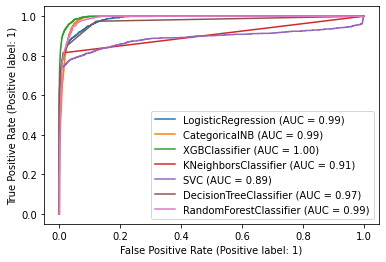

In [12]:
from sklearn.metrics import plot_roc_curve

ax = plt.gca()
for model in models:
    plot_roc_curve(model, X_test, y_test, ax=ax)

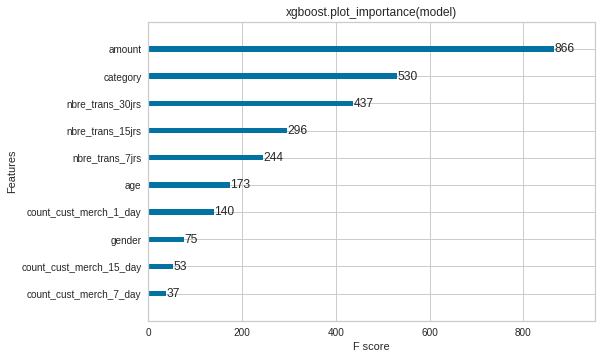

In [84]:
import xgboost
xgboost.plot_importance(models[2])
plt.title("xgboost.plot_importance(model)")
plt.show()

In [85]:
import shap
shap_values = shap.TreeExplainer(models[2]).shap_values(X_test)

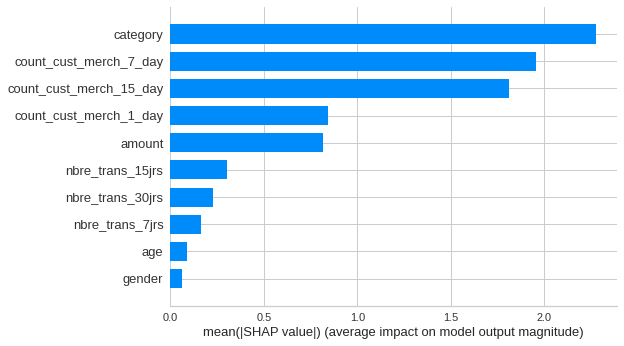

In [86]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

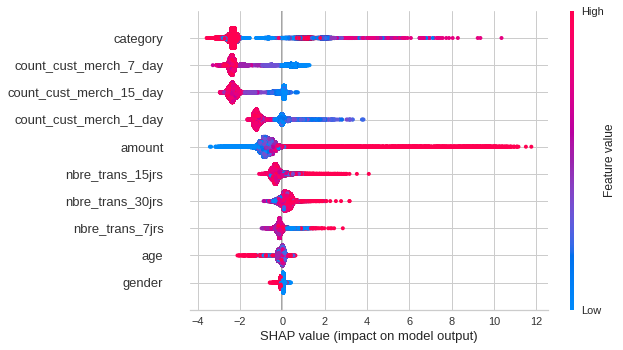

In [87]:
shap.summary_plot(shap_values, X_test)

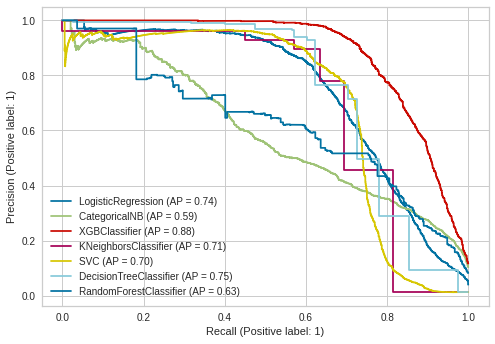

In [71]:
from sklearn.metrics import plot_precision_recall_curve

ax = plt.gca()
for model in models:
    plot_precision_recall_curve(model, X_test, y_test, ax=ax)

/home/muhammad/.cache/pypoetry/virtualenvs/fraud-creditcard-ml-ansh3wJ6-py3.8/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


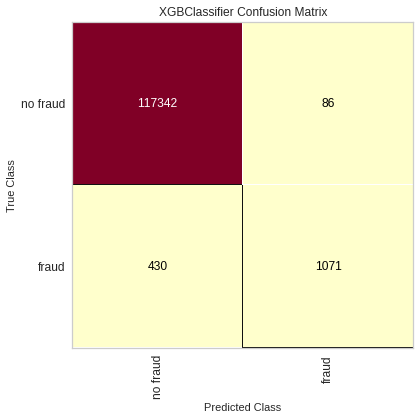

<AxesSubplot:title={'center':'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [46]:
import matplotlib.pyplot as plt
from yellowbrick.classifier import ConfusionMatrix

mapping = {0: "no fraud", 1: "fraud"}
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
    models[2],
    classes=["no fraud","fraud"],
    label_encoder=mapping,
)
cm_viz.score(X_test, y_test)
cm_viz.poof()

In [18]:
from sklearn.metrics import confusion_matrix
y_pred = models[2].predict(X_test)
confusion_matrix(y_test, y_pred)

array([[117342,     86],
       [   430,   1071]])

In [62]:
# TP + TN / (TP + FP + TN + FN)
from sklearn.metrics import accuracy_score

for model in models:
    y_pred = model.predict(X_test)
    print(
    f"{model.__class__.__name__:22}: Accuracy = {accuracy_score(y_test, y_pred)} \n"
    )

LogisticRegression    : Accuracy = 0.9934835069663412 

CategoricalNB         : Accuracy = 0.9555028630527458 

XGBClassifier         : Accuracy = 0.9956612768962995 

KNeighborsClassifier  : Accuracy = 0.9944588788268631 

SVC                   : Accuracy = 0.9940384599214658 

DecisionTreeClassifier: Accuracy = 0.9946102296328061 

RandomForestClassifier: Accuracy = 0.9181192139848144 



In [63]:
# TP / (TP + FP)
from sklearn.metrics import precision_score

for model in models:
    y_pred = model.predict(X_test)
    print(
    f"{model.__class__.__name__:22}: Precision = {precision_score(y_test, y_pred)} \n"
    )

LogisticRegression    : Precision = 0.8773388773388774 

CategoricalNB         : Precision = 0.21466205027848864 

XGBClassifier         : Precision = 0.9256698357821953 

KNeighborsClassifier  : Precision = 0.896421845574388 

SVC                   : Precision = 0.8991935483870968 

DecisionTreeClassifier: Precision = 0.9274353876739563 

RandomForestClassifier: Precision = 0.13171778592506483 



In [65]:
# TP / (TP + FN)
from sklearn.metrics import recall_score

for model in models:
    y_pred = model.predict(X_test)
    print(
    f"{model.__class__.__name__:22}: Recall = {recall_score(y_test, y_pred)} \n"
    )

LogisticRegression    : Recall = 0.5622918054630246 

CategoricalNB         : Recall = 0.950033311125916 

XGBClassifier         : Recall = 0.7135243171219188 

KNeighborsClassifier  : Recall = 0.6342438374417055 

SVC                   : Recall = 0.5942704863424384 

DecisionTreeClassifier: Recall = 0.6215856095936043 

RandomForestClassifier: Recall = 0.9813457694870087 



In [16]:
# (2 * precision * recall) / (precision + recall)
from sklearn.metrics import f1_score

for model in models:
    y_pred = model.predict(X_test)
    print(
    f"{model.__class__.__name__:22}: f1_score = {f1_score(y_test, y_pred)} \n"
    )

LogisticRegression    : f1_score = 0.6853430775477061 

CategoricalNB         : f1_score = 0.350196463654224 

XGBClassifier         : f1_score = 0.8058690744920994 

KNeighborsClassifier  : f1_score = 0.7428794381584082 

SVC                   : f1_score = 0.7156036903329323 

DecisionTreeClassifier: f1_score = 0.744315915436777 

RandomForestClassifier: f1_score = 0.23226111636707664 



### Optimisation du modèle

In [76]:
models[2]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [77]:
from sklearn.model_selection import GridSearchCV
rf_cls = XGBClassifier()
params = {
    "max_depth": [3, 4, 5, 6, 7],
    "random_state": [28]
}
cv = GridSearchCV(
    rf_cls, 
    params, 
    n_jobs=-1
).fit(X_train, y_train)
print(cv.best_params_)

/home/muhammad/.cache/pypoetry/virtualenvs/fraud-creditcard-ml-ansh3wJ6-py3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:54:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'max_depth': 4, 'random_state': 28}


In [79]:
from sklearn.metrics import roc_auc_score
best = XGBClassifier(**cv.best_params_)
best.fit(X_train, y_train)
y_pred2 = best.predict(X_test)
roc_auc_score(y_test, y_pred2)

/home/muhammad/.cache/pypoetry/virtualenvs/fraud-creditcard-ml-ansh3wJ6-py3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.854055682059742

### Features Importance

In [20]:
for col, val in sorted(
    zip(
        X_train.columns,
        models[2].feature_importances_,
    ),
    key=lambda x: x[1],
    reverse=True,
)[:20]:
    print(f"{col:10}{val:10.3f}")

count_cust_merch_7_day     0.594
amount         0.175
category       0.073
count_cust_merch_15_day     0.041
count_cust_merch_1_day     0.038
nbre_trans_7jrs     0.022
nbre_trans_15jrs     0.020
nbre_trans_30jrs     0.020
gender         0.010
age            0.007


/home/muhammad/.cache/pypoetry/virtualenvs/fraud-creditcard-ml-ansh3wJ6-py3.8/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


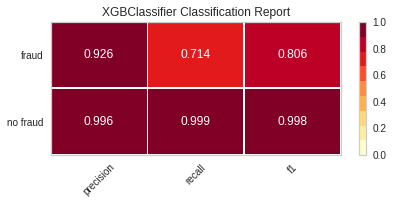

<AxesSubplot:title={'center':'XGBClassifier Classification Report'}>

In [70]:
import matplotlib.pyplot as plt
from yellowbrick.classifier import (
    ClassificationReport,
)

fig, ax = plt.subplots(figsize=(6, 3))
cm_viz = ClassificationReport(
    models[2],
    classes=["no fraud", "fraud"],
    label_encoder=mapping
)
cm_viz.score(X_test, y_test)
cm_viz.poof()

## Training du model final

In [27]:
# ignorer les FuturWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [18]:
import os
from creditcard_mod import helpers

data_all = helpers.load_csv('../datasets/first_features.csv')
# titanic.tail()

In [19]:
data_all.head()

,age,gender,category,amount,fraud,count_cust_merch_1_day,count_cust_merch_7_day,count_cust_merch_15_day,nbre_trans_7jrs,nbre_trans_15jrs,nbre_trans_30jrs
0,4,2,12,4.55,0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2,12,39.68,0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,1,12,26.89,0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2,12,17.25,0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2,12,35.72,0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
target = data_all.fraud
features = data_all.drop("fraud", axis=1)

In [21]:
features.tail()

,age,gender,category,amount,count_cust_merch_1_day,count_cust_merch_7_day,count_cust_merch_15_day,nbre_trans_7jrs,nbre_trans_15jrs,nbre_trans_30jrs
594638,3,1,12,20.53,29.0,6.0,14.0,6.0,14.0,30.0
594639,4,1,12,50.73,25.0,6.0,12.0,6.0,14.0,29.0
594640,2,1,2,22.44,0.0,0.0,0.0,5.0,14.0,29.0
594641,5,2,12,14.46,24.0,4.0,11.0,6.0,14.0,29.0
594642,4,1,12,26.93,26.0,6.0,13.0,6.0,14.0,30.0


In [22]:
final_params = models[2].get_params()
final_params

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [28]:
gb_cls_final = XGBClassifier(**final_params)
gb_cls_final.fit(features, target)

[15:27:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
from datetime import datetime
import joblib

def persist_model(model, name='creditcard-fraud-prediction-ml', directory='../../models'):
    if not os.path.isdir(directory):
        os.makedirs(directory)
    timestamp = datetime.now().isoformat(timespec='seconds')
    filename = f'{directory}/{name}-{timestamp}.joblib'
    joblib.dump(model, filename)
    print(f"The model is saved in {directory}")
    return None

In [31]:
persist_model(gb_cls_final)

The model is saved in ../../models


In [29]:
import pickle 
pickle_out = open("classifier.pkl", mode = "wb") 
pickle.dump(gb_cls_final, pickle_out) 
pickle_out.close()

In [34]:
data_train["gender"].value_counts()

1    324565
2    268385
0      1178
3       515
Name: gender, dtype: int64